# Introduction and Objective

================================================

Milestone 2

Name: Muhammad Irfan Hilmi

Batch: FTDS 026

=================================================

This milestone has the objective to understand and implement the concept of machine learning, which is supervised learning of classification in this particular case. The objective also includes preparing the data to be used for the model training, such as handling missing values and outliers, encoding, and scaling the data. This milestone also has the objective to implement model improvement and hyperparameter tuning and finally deploy said model.

## Problem Statement

Rainfall is one of the most important factors in agriculture since it provides water for crops. This is especially true for places that are usually dry and don’t receive much rainfall, such as Australia. Therefore, rainfall prediction is rather important for farmers and agricultural workers in Australia since it helps them manage and prepare their water resources more effectively and efficiently. This project aims to solve this problem and enables a more efficient water resource management for farmers.

Therefore, this model is created to help solve the water management problem by predicting whether or not there will be rain tomorrow so farmers can prepare accordingly.

https://www.visualcrossing.com/resources/blog/how-does-weather-affect-agriculture/#:~:text=Precipitation%20Since%20precipitation%20is%20the%20primary%20source,rainfall%20helps%20ensure%20those%20needs%20are%20met

https://www.nature.com/articles/103447b0

## Dataset Description and Classification Target

The dataset for the model are sourced from https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package

The dataset has the following columns:

```Date```: The date of observation

```Location```: The common name of the location of the weather station

```MinTemp```: The minimum temperature in degrees celsius

```MaxTemp```: The maximum temperature in degrees celsius

```Rainfall```: The amount of rainfall recorded for the day in mm

```Evaporation```: The so-called Class A pan evaporation (mm) in the 24 hours to 9am

```Sunshine```: The number of hours of bright sunshine in the day

```WindGustDir```: The direction of the strongest wind gust in the 24 hours to midnight

```WindGustSpeed```: The speed (km/h) of the strongest wind gust in the 24 hours to midnight

```WindDir9am```: Direction of the wind at 9am

```WindDir3pm```: Direction of the wind at 3pm

```WindSpeed9am```: Wind speed (km/hr) averaged over 10 minutes prior to 9am

```WindSpeed3pm```: Wind speed (km/hr) averaged over 10 minutes prior to 3pm

```Humidity9am```: Humidity (percent) at 9am

```Humidity3pm```: Humidity (percent) at 3pm

```Pressure9am```: Atmospheric pressure (hpa) reduced to mean sea level at 9am

```Pressure3pm```: Atmospheric pressure (hpa) reduced to mean sea level at 3pm

```Cloud9am```: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. A 0 measure indicates
completely clear sky whilst an 8 indicates that it is completely overcast

```Cloud3pm```: Fraction of sky obscured by cloud (in "oktas": eighths) at 3pm

```Temp9am```: Temperature (degrees C) at 9am

```Temp3pm```: Temperature (degrees C) at 3pm

```RainToday```: Boolean: 1 if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 0

```RainTomorrow```: Boolean: 1 if precipitation (mm) in the next day exceeds 1mm, otherwise 0. Target for the classification

# Import Libraries and Definitions

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from feature_engine.outliers import Winsorizer

from imblearn.over_sampling import SMOTENC

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, TargetEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report

## Constant Definitions

In [232]:
# Random state to be used
random_state = 342101154

# Processor cores to be used
n_jobs = -1

## Functions Definition

In [233]:
def get_dist_bound(data: pd.Series, method: str="auto") -> tuple[float, float]:
    """
    Calculate the lower bound and upper bound for outlier for a distribution.
    Calculation is done with z-score (gaussian) or IQR.

    Args:
        data:   pandas.Series
                Numeric distribution data
        method: {"auto", "iqr", "gaussian"}, default="auto"
                Calculation method, if "auto" then depends on the skewness, use gaussian if ```abs(data.skew())``` <= 0.5, otherwise IQR.

    Returns:
        low_bound: Lower bound of outlier
        up_bound : Upper bound of outlier
    """
    skewed = True if method == "iqr" else False if method == "gaussian" else abs(data.skew()) > 0.5

    low_bound = 0
    up_bound = 0

    if skewed:
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)

        iqr = q3 - q1
        low_bound = q1 - iqr * 1.5
        up_bound = q3 + iqr * 1.5
    else:
        mean = data.mean()
        std = data.std()

        low_bound = mean - std * 3
        up_bound = mean + std * 3

    return low_bound, up_bound

In [234]:
def calculate_outliers(data: pd.DataFrame, labels: list[str] | None = None, method: list[str] | None = None) -> pd.DataFrame:
    outliers = {
        "column": [],
        "skewness": [],
        "outliers_percentage": []
    }

    if labels == None:
        labels = data.columns
    
    for pos, label in enumerate(labels):
        mth = "auto" if method == None else method[pos]
        low_bound, up_bound = get_dist_bound(data[label], method=mth)
        
        outliers["column"].append(label)
        outliers["skewness"].append(data[label].skew())
        outliers["outliers_percentage"].append(len(data[(data[label] < low_bound) | (data[label] > up_bound)]) / len(data[label]) * 100)

    return pd.DataFrame(outliers)

In [235]:
def calculate_missing(data: pd.DataFrame) -> pd.DataFrame:
    df = {
    "columns": [],
    "skewness": [],
    "count": [],
    "missing_percentage": []
    }

    columns = data.columns

    count = len(data)
    for i in columns:
        skewness = pd.NA
        try:
            skewness = data[i].skew()
        except:
            pass

        missing_count = data[i].isnull().sum()
        df["columns"].append(i)
        df["skewness"].append(skewness)
        df["count"].append(missing_count)
        df["missing_percentage"].append(missing_count / count * 100)

    return pd.DataFrame(df)

In [236]:
def chi2_contingency_with_cramers_v(confusion_matrix):
    chi2, pval, df, expected = stats.chi2_contingency(confusion_matrix)

    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape

    return np.sqrt(chi2 / (n * (min(r, k) - 1))), chi2, pval, df, expected

## Class Definitions

In [237]:
class MissingIndicatorImputer(BaseEstimator, TransformerMixin):
    """
    Missing values imputer similar to ```SimpleImputer``` but add a missing value flag columns to indicate missingness
    """
    def __init__(self, strategy: str="mean", fill_value=None) -> None:
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}
        self.new_col_str = "missing_"
        self.columns = []

    def fit(self, X, y = None):
        df = pd.DataFrame(X)

        self.columns = df.columns
        for col in df.columns:
            if self.strategy == "constant":
                self.fill_values_[col] = self.fill_value
            elif self.strategy == "mode":
                self.fill_values_[col] = df[col].mode()[0]
            elif self.strategy == "mean":
                self.fill_values_[col] = df[col].mean()
            elif self.strategy == "median":
                self.fill_values_[col] = df[col].median()
            else:
                raise ValueError("Unknown fill strategy")
        
        return self
        
    def transform(self, X):
        df = pd.DataFrame(X).copy()

        for col in self.columns:
            missing_col_name = f"{self.new_col_str}{col}"
            df[missing_col_name] = df[col].isnull().astype(int)
            df[col] = df[col].fillna(self.fill_values_[col])

        return df
    
    def get_feature_names_out(self, input_features=None):
        return [col for col in self.columns] + [f"{self.new_col_str}{col}" for col in self.columns]

In [238]:
# Not used

class DependentImputer(BaseEstimator, TransformerMixin):
    def __init__(self, dependency_column: str, fill_function) -> None:
        super().__init__()

        self.dependency_column = dependency_column
        self.fill_function = fill_function
        self.fill_values_ = {}

    def fit(self, X, y) -> None:
        df = pd.DataFrame(X)

        for col in df.columns:
            if self.strategy == "constant":
                self.fill_values_[col] = self.fill_value
            elif self.strategy == "mode":
                self.fill_values_[col] = df[col].mode()[0]
            elif self.strategy == "mean":
                self.fill_values_[col] = df[col].mean()
            elif self.strategy == "median":
                self.fill_values_[col] = df[col].median()
            else:
                raise ValueError("Unknown fill strategy")
        
    def transform(self, X) -> pd.DataFrame:
        df = pd.DataFrame(X).copy()

        for col in df.columns:
            missing_col_name = f"missing_{col}"
            df[missing_col_name] = df[col].isnull().astype(int)
            df[col].fillna(self.fill_values_[col], inplace=True)

        return df

# Data Loading

This section performs loading of the data and also perform basic data cleaning, such as converting data types, dropping duplicates or missing target, and also dropping invalid entry in the data.

In [239]:
data = pd.read_csv("weatherAUS.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [240]:
data["Date"] = data["Date"].astype("datetime64[ns]")

In [241]:
data.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

The target column has 3267 of missing data, since this is the target of the data, no assumption will be made about the missing values and only complete target will be used instead.

In [242]:
data_complete_target = data.dropna(subset=("RainTomorrow"))

data_complete_target.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [243]:
data_complete_target.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,142193,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,2013-04-01 00:28:51.730816512,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
min,2007-11-01 00:00:00,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,2011-01-06 00:00:00,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,2013-05-27 00:00:00,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,2015-06-12 00:00:00,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,2017-06-25 00:00:00,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000
std,NaN,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594


From the description ```Cloud9am``` and ```Cloud3pm``` are measured in oktas, which means the value cannot exceed 8. It can be seen from the maximum value, both of those columns contain invalid number, which is 9. There are 3 instances where this is the case. This can be deemed invalid and thus will be discarded.

In [244]:
# Check invalid data

data_complete_target[(data_complete_target["Cloud9am"] > 8) | (data_complete_target["Cloud3pm"] > 8)]

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
30776,2009-09-23,Sydney,17.0,21.8,4.4,11.2,8.0,NaN,NaN,W,...,40.0,36.0,996.8,997.8,9.0,3.0,17.3,20.9,Yes,No
47226,2012-05-27,Canberra,0.6,14.5,0.0,NaN,7.8,SW,30.0,NNW,...,99.0,41.0,1022.4,1020.7,9.0,NaN,4.4,14.2,No,No
106933,2012-11-02,Woomera,10.6,24.6,0.2,11.6,11.4,SSE,39.0,SE,...,45.0,13.0,1019.0,1015.2,6.0,9.0,14.8,23.7,No,No


In [245]:
# Discard invalid data

data_complete_target = data_complete_target[~((data_complete_target["Cloud9am"] > 8) | (data_complete_target["Cloud3pm"] > 8))]

In [246]:
data_complete_target[["Cloud9am", "Cloud3pm"]].describe()

,Cloud9am,Cloud3pm
count,88533.000000,85097.000000
mean,4.437069,4.503132
std,2.886978,2.720616
min,0.000000,0.000000
25%,1.000000,2.000000
50%,5.000000,5.000000
75%,7.000000,7.000000
max,8.000000,8.000000


# Exploratory Data Analysis Part 1

This part serves and initial exploratory data analysis to serve as the basis for the feature engineering of the data. This section of the analysis focuses on the dataset before it is split into training and test data.

## Target Data Balance

This analyze the balance of the target labels. It can be seen that the target is quite imbalanced with the ratio of around 4:1 with the majority being ```No``` for the target. This imbalance could cause the model to only see the majority target and ignore the other classification target. Therefore, data balancing can be done to potentially improve the performance of the model.

<Axes: xlabel='RainTomorrow'>

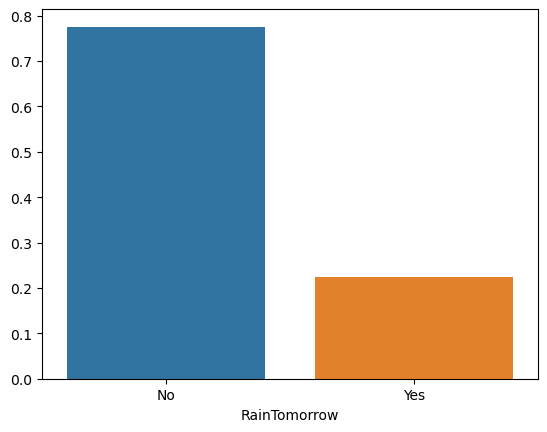

In [247]:
yes_label = data_complete_target["RainTomorrow"][data_complete_target["RainTomorrow"] == "Yes"]
no_label = data_complete_target["RainTomorrow"][data_complete_target["RainTomorrow"] == "No"]

labels = data_complete_target.groupby("RainTomorrow")[["RainTomorrow"]].count()
total = labels.sum()
labels = labels / total

sns.barplot(data=labels.T)

## Missing Values Analysis

This section analyze the missing values present in the data and perform exploratory analysis to determine the type of missingness of the data so it can be handled properly.

There are a lot of missing values from the data, particularly rainfall, evaporation, and cloud cover data. Based on the description of the data, each weather measurements entry are independent on each other. Therefore, it is unlikely that the missingness of the measurements are dependent on the observed data.

In [248]:
df = calculate_missing(data_complete_target).set_index("columns")

df

,skewness,count,missing_percentage
columns,,,
Date,<NA>,0,0.000000
Location,<NA>,0,0.000000
MinTemp,0.023912,637,0.447992
MaxTemp,0.224905,322,0.226458
Rainfall,9.887971,1406,0.988818
Evaporation,3.7471,60842,42.789226
Sunshine,-0.502879,67816,47.693931
WindGustDir,<NA>,9329,6.560940
WindGustSpeed,0.874288,9269,6.518743


In [249]:
data_complete_target[["Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"]].describe()

,Evaporation,Sunshine,Cloud9am,Cloud3pm
count,81348.000000,74374.000000,88533.000000,85097.000000
mean,5.469678,7.624795,4.437069,4.503132
std,4.188485,3.781576,2.886978,2.720616
min,0.000000,0.000000,0.000000,0.000000
25%,2.600000,4.900000,1.000000,2.000000
50%,4.800000,8.500000,5.000000,5.000000
75%,7.400000,10.600000,7.000000,7.000000
max,145.000000,14.500000,8.000000,8.000000


From the descriptive statistic of the data, the data itself does not show any anomaly regarding their values. All the values has their maximum and minimum value within acceptable range. Therefore, it is unlikely that the missing data itself is MNAR (missing not at random).

Therefore, the missing data will be imputed with their mean/median depending on their distribution along with adding a flag to indicate their missingness.

In [250]:
len(data_complete_target[data_complete_target["Rainfall"].isnull() & data_complete_target["RainToday"].isnull()])

1406

Another thing that can be inferred from the domain knowledge of the data is the missingness of ```Rainfall``` and ```RainToday``` data, which perfectly corresponds to each other. It can be assumed that the missing data are simply not measured for that entry.

## Numerical Data Distribution

This section analyze the distribution and also skewness of the numerical data distribution to determine the imputer type and also visualize the outliers.

<Axes: >

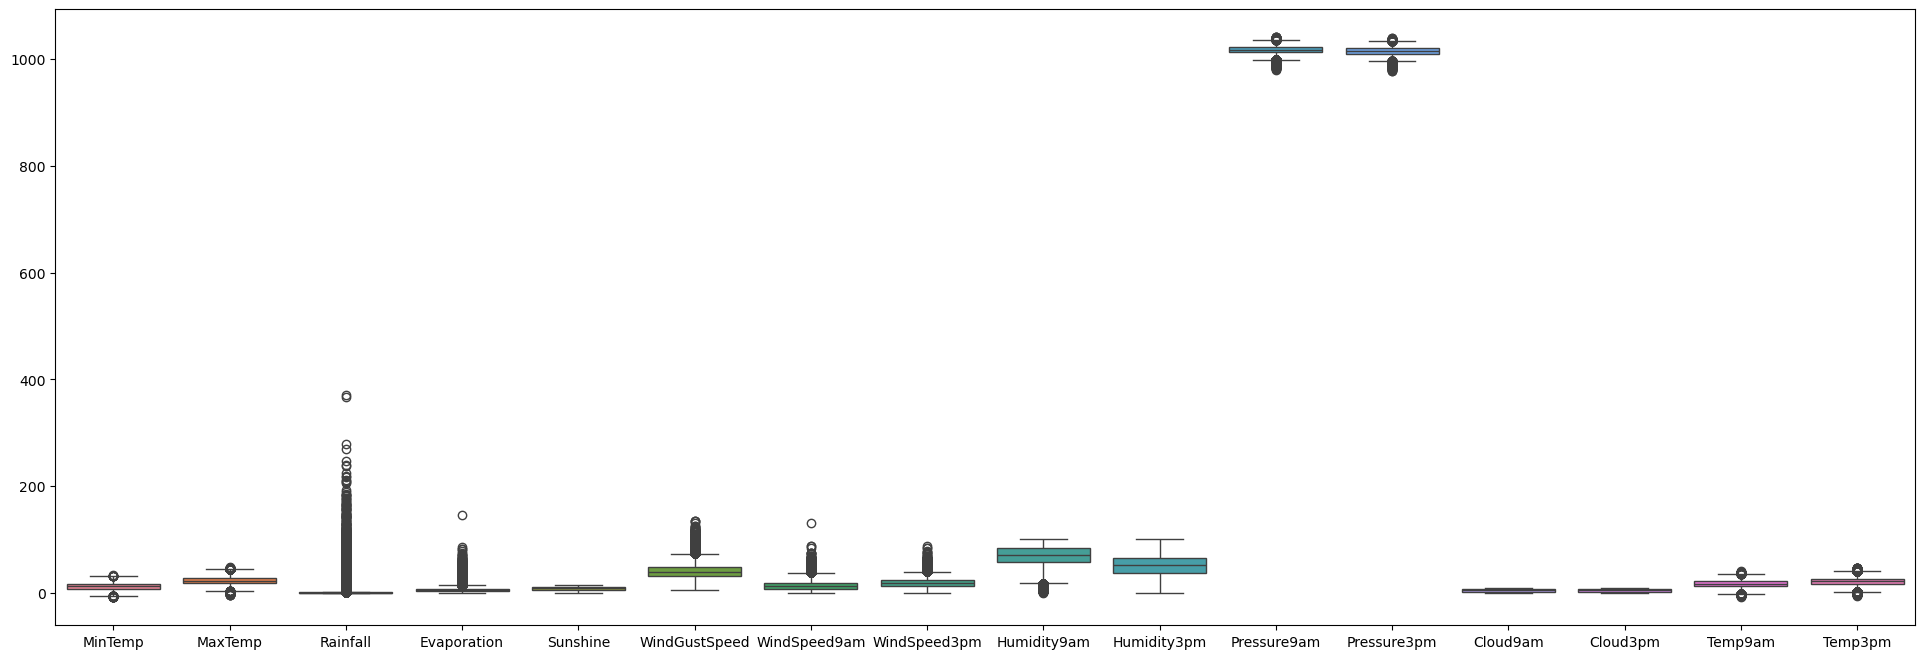

In [251]:
fig, ax = plt.subplots(1, 1, figsize=(24, 8))
sns.boxplot(data=data_complete_target, ax=ax)

<Axes: >

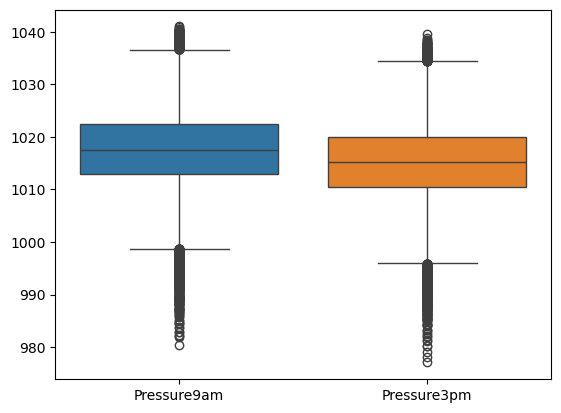

In [252]:
sns.boxplot(data=data_complete_target[["Pressure9am", "Pressure3pm"]])

In [253]:
calculate_outliers(data=data_complete_target[["Pressure9am", "Pressure3pm"]])

,column,skewness,outliers_percentage
0,Pressure9am,-0.096074,0.350939
1,Pressure3pm,-0.046125,0.296083


As can be observed, the pressure measurement data has a fairly normal distribution and only less than half a percent outliers. For this, the outliers for this data will not be handled.

<Axes: >

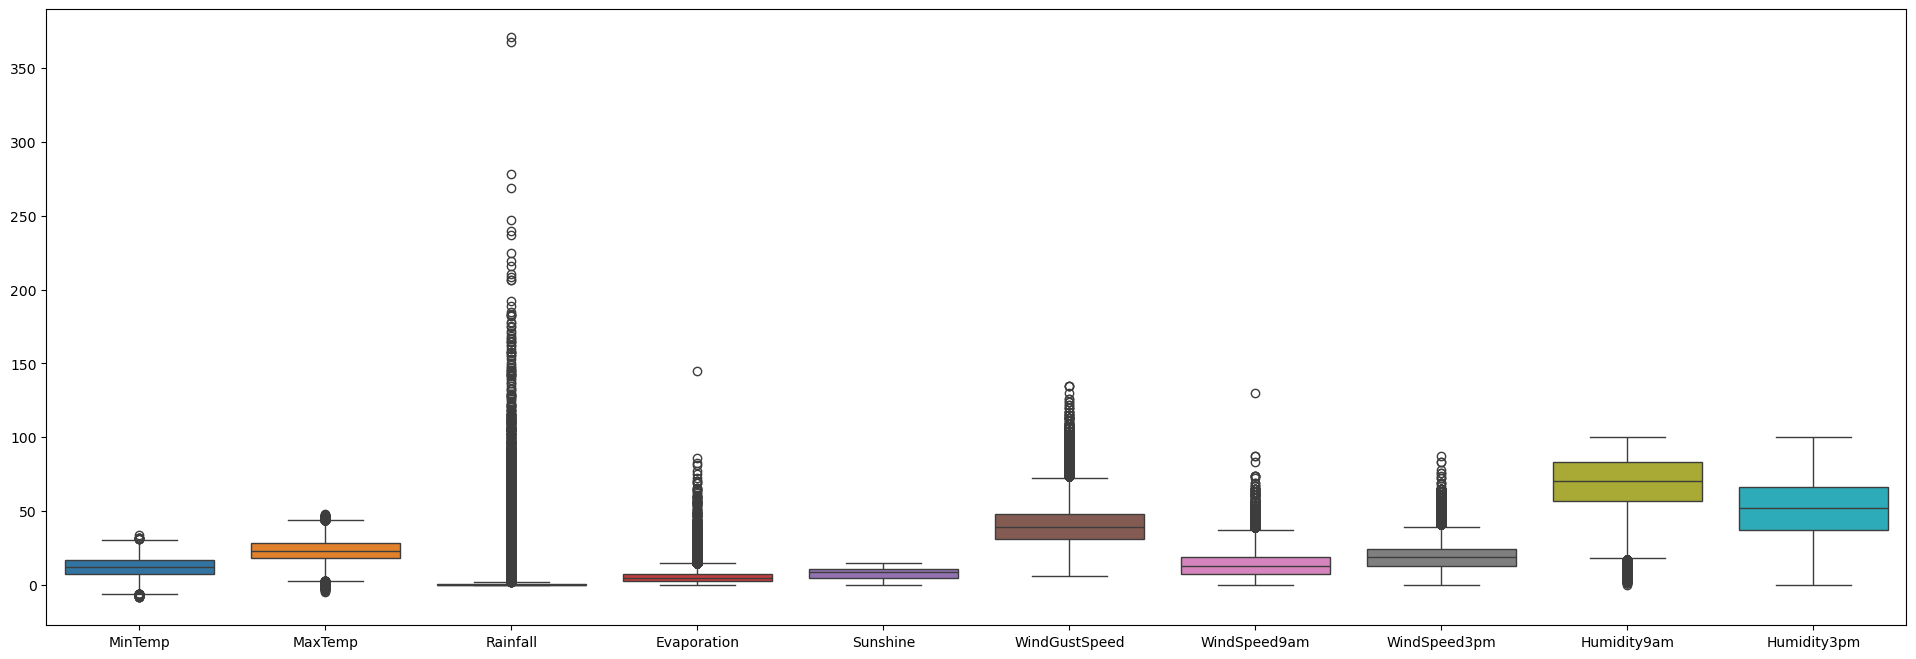

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(24, 8))
sns.boxplot(data=data_complete_target[["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]], ax=ax)

In [255]:
calculate_outliers(data=data_complete_target[["MinTemp", "MaxTemp", "Rainfall", "Evaporation", "Sunshine", "WindGustSpeed", "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm"]])

,column,skewness,outliers_percentage
0,MinTemp,0.023912,0.013362
1,MaxTemp,0.224905,0.217315
2,Rainfall,9.887971,17.741754
3,Evaporation,3.747100,1.374218
4,Sunshine,-0.502879,0.000000
5,WindGustSpeed,0.874288,2.114073
6,WindSpeed9am,0.775532,1.223011
7,WindSpeed3pm,0.631425,1.728673
8,Humidity9am,-0.482863,0.331247
9,Humidity3pm,0.034499,0.000000


From the chart above, it can be seen that only the rainfall data has a significant number of outliers, not only that, it is highly skewed. Therefore, any data imputation and outlier handling for this data will be used based on their median. Other columns distribution does not seem to have a lot of outliers.

<Axes: >

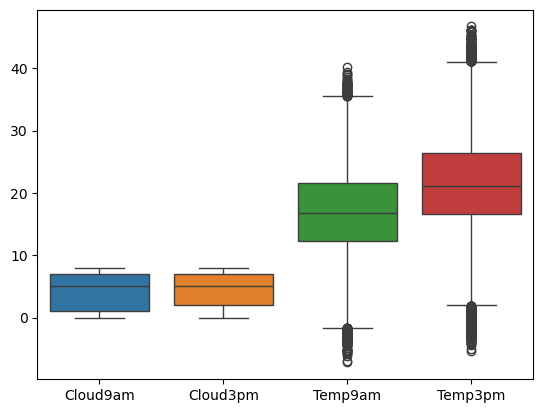

In [256]:
sns.boxplot(data=data_complete_target[["Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm"]])

In [257]:
calculate_outliers(data=data_complete_target[["Cloud9am", "Cloud3pm", "Temp9am", "Temp3pm"]])

,column,skewness,outliers_percentage
0,Cloud9am,-0.224267,0.000000
1,Cloud3pm,-0.224114,0.000000
2,Temp9am,0.091394,0.097053
3,Temp3pm,0.240044,0.260215


As for the 9am and 3pm cloud cover and temperature data, the distributions seem to be within normal range and their outliers percentage are also quite small. Therefore, those data also will not go through handling of their outliers.

# Feature Engineering Part 1

## Split Features and Target

Split the data into features and target, the features being all the columns except ```RainTomorrow```, which is the target.

In [258]:
X = data_complete_target.drop("RainTomorrow", axis=1)
Y = data_complete_target["RainTomorrow"]

X

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No


## Split Between Train and Test Data

Split the data into train and test data with the train and test data being 75% and 25% of the original data respectively.

In [259]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=random_state)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106642 entries, 124013 to 95705
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           106642 non-null  datetime64[ns]
 1   Location       106642 non-null  object        
 2   MinTemp        106151 non-null  float64       
 3   MaxTemp        106397 non-null  float64       
 4   Rainfall       105549 non-null  float64       
 5   Evaporation    60876 non-null   float64       
 6   Sunshine       55703 non-null   float64       
 7   WindGustDir    99589 non-null   object        
 8   WindGustSpeed  99629 non-null   float64       
 9   WindDir9am     99034 non-null   object        
 10  WindDir3pm     103788 non-null  object        
 11  WindSpeed9am   105607 non-null  float64       
 12  WindSpeed3pm   104649 non-null  float64       
 13  Humidity9am    105284 non-null  float64       
 14  Humidity3pm    103922 non-null  float64       
 15  P

## Split Numerical and Categorical Columns

In [260]:
num_cols = X_train.select_dtypes("float64").columns.to_list()
cat_cols = X_train.select_dtypes("object").columns.to_list()

print(num_cols)
print(cat_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


## Missing Values Handling

In [261]:
df = calculate_missing(X_train).set_index("columns")

df

,skewness,count,missing_percentage
columns,,,
Date,<NA>,0,0.000000
Location,<NA>,0,0.000000
MinTemp,0.026787,491,0.460419
MaxTemp,0.229106,245,0.229741
Rainfall,9.976874,1093,1.024925
Evaporation,3.755607,45766,42.915549
Sunshine,-0.504014,50939,47.766358
WindGustDir,<NA>,7053,6.613717
WindGustSpeed,0.867055,7013,6.576208


### Determine Imputer For Numerical Columns

In [262]:
num_missing = df[df.index.isin(num_cols)]
num_missing

,skewness,count,missing_percentage
columns,,,
MinTemp,0.026787,491,0.460419
MaxTemp,0.229106,245,0.229741
Rainfall,9.976874,1093,1.024925
Evaporation,3.755607,45766,42.915549
Sunshine,-0.504014,50939,47.766358
WindGustSpeed,0.867055,7013,6.576208
WindSpeed9am,0.784192,1035,0.970537
WindSpeed3pm,0.634247,1993,1.868870
Humidity9am,-0.47771,1358,1.273419


#### Median Imputer

In [263]:
num_missing_med = num_missing[(abs(num_missing["skewness"]) > 0.5) & (num_missing["missing_percentage"] < 5)]

num_missing_med

,skewness,count,missing_percentage
columns,,,
Rainfall,9.976874,1093,1.024925
WindSpeed9am,0.784192,1035,0.970537
WindSpeed3pm,0.634247,1993,1.868870


In [264]:
median_imputer = SimpleImputer(strategy="median")

#### Mean Imputer

In [265]:
num_missing_mean = num_missing[(abs(num_missing["skewness"]) <= 0.5) & (num_missing["missing_percentage"] < 5)]

num_missing_mean

,skewness,count,missing_percentage
columns,,,
MinTemp,0.026787,491,0.460419
MaxTemp,0.229106,245,0.229741
Humidity9am,-0.47771,1358,1.273419
Humidity3pm,0.035449,2720,2.550590
Temp9am,0.095734,696,0.652651
Temp3pm,0.245871,2052,1.924195


In [266]:
mean_imputer = SimpleImputer(strategy="mean")

#### Median Imputer With Flag

In [267]:
num_missing_median_w_flag = num_missing[num_missing.index.isin(["Cloud9am", "Cloud3pm", "Evaporation", "Sunshine", "WindGustSpeed"])]

num_missing_median_w_flag

,skewness,count,missing_percentage
columns,,,
Evaporation,3.755607,45766,42.915549
Sunshine,-0.504014,50939,47.766358
WindGustSpeed,0.867055,7013,6.576208
Cloud9am,-0.223688,40393,37.877197
Cloud3pm,-0.225275,42926,40.252433


In [268]:
median_imputer_w_flag = MissingIndicatorImputer(strategy="median")

#### Mean Imputer With Flag

In [269]:
num_missing_mean_w_flag = num_missing[num_missing.index.isin(["Pressure9am", "Pressure3pm"])]

num_missing_mean_w_flag

,skewness,count,missing_percentage
columns,,,
Pressure9am,-0.090769,10569,9.910729
Pressure3pm,-0.038719,10551,9.893850


In [270]:
mean_imputer_w_flag = MissingIndicatorImputer(strategy="mean")

#### Mode Imputer

In [271]:
cat_missing_mode = df[df.index.isin(["RainToday"])]

cat_missing_mode

,skewness,count,missing_percentage
columns,,,
RainToday,<NA>,1093,1.024925


In [272]:
mode_imputer = SimpleImputer(strategy="most_frequent")

#### Constant Value Imputer

In [273]:
cat_missing_constant = df[df.index.isin(["Location", "WindGustDir", "WindDir9am", "WindDir3pm"])]

cat_missing_constant

,skewness,count,missing_percentage
columns,,,
Location,<NA>,0,0.000000
WindGustDir,<NA>,7053,6.613717
WindDir9am,<NA>,7608,7.134150
WindDir3pm,<NA>,2854,2.676244


In [274]:
constant_imputer = SimpleImputer(strategy="constant", fill_value="Unknown")

### Imputer Transformer

In [275]:
imputer_transformer = ColumnTransformer([
    ("median_imputer", median_imputer, num_missing_med.index),
    ("mean_imputer", mean_imputer, num_missing_mean.index),
    ("median_imputer_w_flag", median_imputer_w_flag, num_missing_median_w_flag.index),
    ("mean_imputer_w_flag", mean_imputer_w_flag, num_missing_mean_w_flag.index),
    ("mode_imputer", mode_imputer, cat_missing_mode.index),
    ("unknown_constant_imputer", constant_imputer, cat_missing_constant.index)
], verbose_feature_names_out=False)

imputer_transformer.set_output(transform="pandas")

ColumnTransformer(transformers=[('median_imputer',
                                 SimpleImputer(strategy='median'),
                                 Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                ('mean_imputer', SimpleImputer(),
                                 Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dtype='object', name='columns')),
                                ('median_imputer_w_flag',
                                 MissingIndicatorImput...
                                 Index(['Pressure9am', 'Pressure3pm'], dtype='object', name='columns')),
                                ('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 Index(['RainToday'], dtype='object', name='columns')),
                                ('unknown_constant_imputer',
                                 SimpleImputer(fill_value='Unknown',
                                               strategy='constant'),
                                 Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object', name='columns'))],
                  verbose_feature_names_out=False)

In [276]:
imputer_transformer.fit(X_train)

X_train_transformed = imputer_transformer.transform(X_train)

X_train_transformed

,Rainfall,WindSpeed9am,WindSpeed3pm,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Temp9am,Temp3pm,Evaporation,...,missing_Cloud3pm,Pressure9am,Pressure3pm,missing_Pressure9am,missing_Pressure3pm,RainToday,Location,WindGustDir,WindDir9am,WindDir3pm
124013,3.4,13.0,11.0,6.600000,14.5,91.000000,69.00000,10.500000,14.400000,4.8,...,1,1017.625743,1015.23375,1,1,Yes,SalmonGums,WSW,WSW,SSW
87434,0.0,19.0,17.0,15.900000,28.0,62.000000,50.00000,22.100000,27.200000,6.0,...,0,1016.700000,1013.50000,0,0,No,Cairns,ESE,SE,ESE
100612,0.0,28.0,24.0,14.300000,23.2,48.000000,41.00000,17.200000,20.400000,10.6,...,0,1020.800000,1021.00000,0,0,No,MountGambier,W,SW,S
17933,0.0,13.0,19.0,12.189007,32.0,68.783566,51.41842,16.994718,21.700945,4.8,...,1,1017.625743,1015.23375,1,1,No,Newcastle,Unknown,Unknown,Unknown
42816,0.0,24.0,35.0,11.800000,19.3,54.000000,61.00000,15.500000,17.600000,4.8,...,1,1016.500000,1012.50000,0,0,No,Wollongong,WNW,NNE,NE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106831,0.0,9.0,13.0,3.800000,17.2,64.000000,31.00000,10.200000,16.500000,16.0,...,0,1027.500000,1023.60000,0,0,No,Woomera,NNE,E,NNE
53863,0.0,13.0,11.0,17.200000,29.9,31.000000,26.00000,21.500000,29.100000,4.8,...,1,1017.625743,1015.23375,1,1,No,MountGinini,ESE,WNW,WNW
62516,0.0,6.0,26.0,1.400000,19.4,69.000000,60.00000,12.100000,16.900000,2.6,...,0,1019.700000,1013.60000,0,0,No,Sale,E,N,E
83668,4.2,28.0,19.0,11.500000,15.1,83.000000,78.00000,13.500000,13.000000,2.0,...,1,996.100000,995.00000,0,0,Yes,Dartmoor,W,NNW,WNW


## Outlier Handling

In [277]:
calculate_outliers(X_train_transformed, labels=num_cols)

,column,skewness,outliers_percentage
0,MinTemp,0.026849,0.017817
1,MaxTemp,0.229370,0.227865
2,Rainfall,10.024913,19.993061
3,Evaporation,5.160079,22.760263
4,Sunshine,-1.110136,42.671743
5,WindGustSpeed,0.911842,3.833386
6,WindSpeed9am,0.791232,1.253727
7,WindSpeed3pm,0.637993,1.765721
8,Humidity9am,-0.480781,0.331014
9,Humidity3pm,0.035910,0.000000


In [278]:
outlier_cols = ["Rainfall"]

capper = Winsorizer(capping_method="iqr", tail="both")

In [279]:
outlier_transformer = ColumnTransformer([
    ("capper", capper, outlier_cols)
], remainder="passthrough", verbose_feature_names_out=False, force_int_remainder_cols=False)

outlier_transformer.set_output(transform="pandas")

ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',
                  transformers=[('capper',
                                 Winsorizer(capping_method='iqr', tail='both'),
                                 ['Rainfall'])],
                  verbose_feature_names_out=False)

In [280]:
pipe = Pipeline([
    ("imputer", imputer_transformer),
    ("capper", outlier_transformer)
])

X_train_capped = pipe.fit_transform(X_train)
X_train_capped

,Rainfall,WindSpeed9am,WindSpeed3pm,MinTemp,MaxTemp,Humidity9am,Humidity3pm,Temp9am,Temp3pm,Evaporation,...,missing_Cloud3pm,Pressure9am,Pressure3pm,missing_Pressure9am,missing_Pressure3pm,RainToday,Location,WindGustDir,WindDir9am,WindDir3pm
124013,1.5,13.0,11.0,6.600000,14.5,91.000000,69.00000,10.500000,14.400000,4.8,...,1,1017.625743,1015.23375,1,1,Yes,SalmonGums,WSW,WSW,SSW
87434,0.0,19.0,17.0,15.900000,28.0,62.000000,50.00000,22.100000,27.200000,6.0,...,0,1016.700000,1013.50000,0,0,No,Cairns,ESE,SE,ESE
100612,0.0,28.0,24.0,14.300000,23.2,48.000000,41.00000,17.200000,20.400000,10.6,...,0,1020.800000,1021.00000,0,0,No,MountGambier,W,SW,S
17933,0.0,13.0,19.0,12.189007,32.0,68.783566,51.41842,16.994718,21.700945,4.8,...,1,1017.625743,1015.23375,1,1,No,Newcastle,Unknown,Unknown,Unknown
42816,0.0,24.0,35.0,11.800000,19.3,54.000000,61.00000,15.500000,17.600000,4.8,...,1,1016.500000,1012.50000,0,0,No,Wollongong,WNW,NNE,NE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106831,0.0,9.0,13.0,3.800000,17.2,64.000000,31.00000,10.200000,16.500000,16.0,...,0,1027.500000,1023.60000,0,0,No,Woomera,NNE,E,NNE
53863,0.0,13.0,11.0,17.200000,29.9,31.000000,26.00000,21.500000,29.100000,4.8,...,1,1017.625743,1015.23375,1,1,No,MountGinini,ESE,WNW,WNW
62516,0.0,6.0,26.0,1.400000,19.4,69.000000,60.00000,12.100000,16.900000,2.6,...,0,1019.700000,1013.60000,0,0,No,Sale,E,N,E
83668,1.5,28.0,19.0,11.500000,15.1,83.000000,78.00000,13.500000,13.000000,2.0,...,1,996.100000,995.00000,0,0,Yes,Dartmoor,W,NNW,WNW


# Exploratory Data Analysis Part 2

## Rainfall Distribution

This section analyze the rainfall measurements distribution of the training data after imputation and outliers handling. It can be seen that a lot of the data is below 1.0, which indicates no rain. Therefore, this data resembles more with the ```RainToday``` column.

<Axes: xlabel='RainToday', ylabel='Rainfall'>

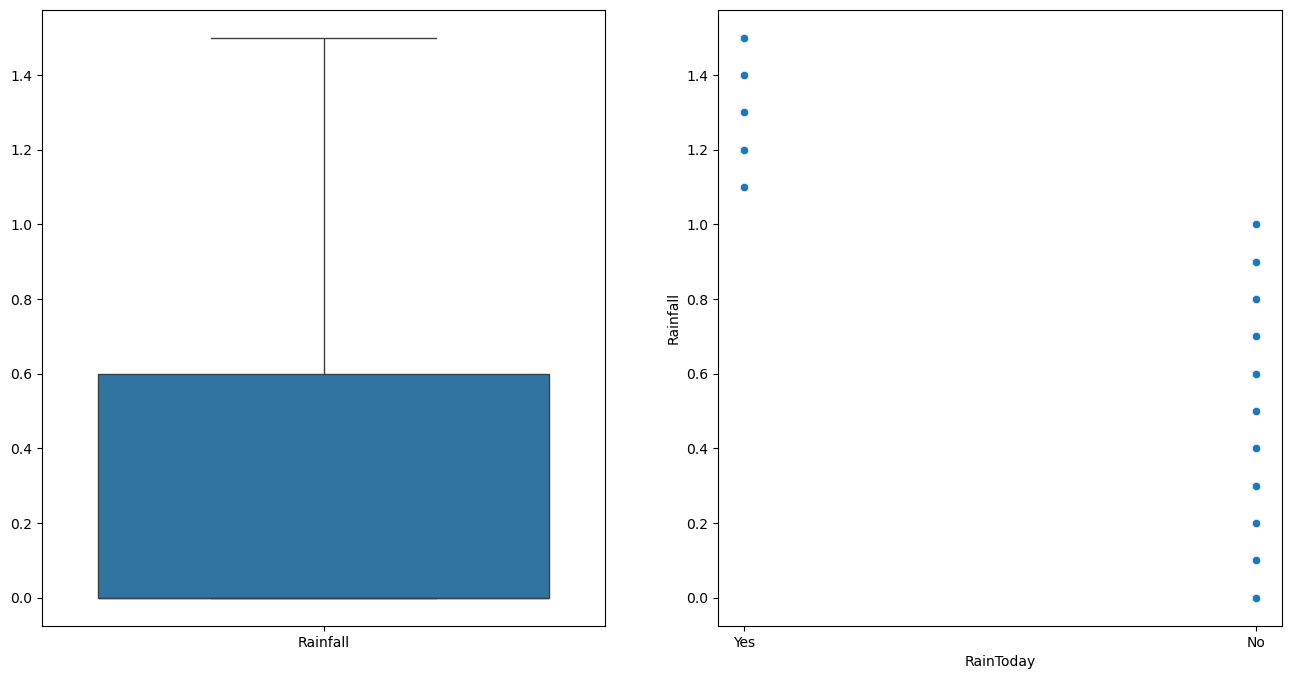

In [281]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(data=X_train_capped[outlier_cols], ax=ax[0])
sns.scatterplot(data=X_train_capped, x="RainToday", y="Rainfall", ax=ax[1])

## Cloud Cover T-Test

This section measures the effect of cloud cover to the target variable using T-test. Both ```Cloud9am``` and ```Cloud3pm``` is known to have a normal distibution. For this test, the null hypothesis is that the mean of cloud cover between the group with target label "Yes" and target label "No" are not statistically different. The result of the test shows P-value of less than 0.5 for both 9am and 3pm cloud cover, which means it rejects the null hypothesis and that the cloud cover has different mean for different group of target label.

In [282]:
label_yes = X_train_capped[Y_train == "Yes"]
label_no = X_train_capped[Y_train == "No"]

st, pval = stats.ttest_ind(label_yes["Cloud9am"], label_no["Cloud9am"])
print(f"T-test for 9am cloud cover: {st}, pval: {pval}")

st, pval = stats.ttest_ind(label_yes["Cloud3pm"], label_no["Cloud3pm"])
print(f"T-test for 3pm cloud cover: {st}, pval: {pval}")

T-test for 9am cloud cover: 83.7649181017265, pval: 0.0
T-test for 3pm cloud cover: 100.68663870934829, pval: 0.0


## Pressure and Temperature T-Test

In [283]:
label_yes = X_train_capped[Y_train == "Yes"]
label_no = X_train_capped[Y_train == "No"]

st, pval = stats.ttest_ind(label_yes["MaxTemp"], label_no["MaxTemp"])
print(f"T-test for maximum temperature: {st}, pval: {pval}")

st, pval = stats.ttest_ind(label_yes["MinTemp"], label_no["MinTemp"])
print(f"T-test for minimum temperature: {st}, pval: {pval}")

st, pval = stats.ttest_ind(label_yes["Temp9am"], label_no["Temp9am"])
print(f"T-test for 9am temperature: {st}, pval: {pval}")

st, pval = stats.ttest_ind(label_yes["Temp3pm"], label_no["Temp3pm"])
print(f"T-test for 3pm temperature: {st}, pval: {pval}")

st, pval = stats.ttest_ind(label_yes["Pressure9am"], label_no["Pressure9am"])
print(f"T-test for 9am pressure: {st}, pval: {pval}")

st, pval = stats.ttest_ind(label_yes["Pressure3pm"], label_no["Pressure3pm"])
print(f"T-test for 3pm pressure: {st}, pval: {pval}")

T-test for maximum temperature: -52.61007685420173, pval: 0.0
T-test for minimum temperature: 27.63188797214323, pval: 1.8017676393222002e-167
T-test for 9am temperature: -8.489525004271679, pval: 2.1009478617301257e-17
T-test for 3pm temperature: -63.48193878022983, pval: 0.0
T-test for 9am pressure: -78.24705619227883, pval: 0.0
T-test for 3pm pressure: -71.17529009970005, pval: 0.0


## Evaporation and Sunshine Mann-Whitney U Test

In [284]:
label_yes = X_train_capped[Y_train == "Yes"]
label_no = X_train_capped[Y_train == "No"]

st, pval = stats.mannwhitneyu(label_yes["Evaporation"], label_no["Evaporation"])
print(f"Mann-Whitney for evaporation: {st}, pval: {pval}")

st, pval = stats.mannwhitneyu(label_yes["Sunshine"], label_no["Sunshine"])
print(f"Mann-Whitney for sunshine: {st}, pval: {pval}")

Mann-Whitney for evaporation: 855753750.5, pval: 4.7322756566148977e-237
Mann-Whitney for sunshine: 596030515.5, pval: 0.0


# Feature Engineering Part 2

In [285]:
X_train_capped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106642 entries, 124013 to 95705
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Rainfall               106642 non-null  float64
 1   WindSpeed9am           106642 non-null  float64
 2   WindSpeed3pm           106642 non-null  float64
 3   MinTemp                106642 non-null  float64
 4   MaxTemp                106642 non-null  float64
 5   Humidity9am            106642 non-null  float64
 6   Humidity3pm            106642 non-null  float64
 7   Temp9am                106642 non-null  float64
 8   Temp3pm                106642 non-null  float64
 9   Evaporation            106642 non-null  float64
 10  Sunshine               106642 non-null  float64
 11  WindGustSpeed          106642 non-null  float64
 12  Cloud9am               106642 non-null  float64
 13  Cloud3pm               106642 non-null  float64
 14  missing_Evaporation    106642 non-nul

In [286]:
X_train_capped.columns

Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp',
       'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'Evaporation',
       'Sunshine', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm',
       'missing_Evaporation', 'missing_Sunshine', 'missing_WindGustSpeed',
       'missing_Cloud9am', 'missing_Cloud3pm', 'Pressure9am', 'Pressure3pm',
       'missing_Pressure9am', 'missing_Pressure3pm', 'RainToday', 'Location',
       'WindGustDir', 'WindDir9am', 'WindDir3pm'],
      dtype='object')

## Splitting Column

This section splits the columns based on their preprocessing. For example, numerical column will be scaled while categorical columns will be encoded. The categorical columns includes missing flag from the imputer just for completeness.

In [287]:
num_cols = X_train_capped.select_dtypes("float64").columns.to_list()
cat_cols = X_train_capped.select_dtypes("int64").columns.to_list() + X_train_capped.select_dtypes("object").columns.to_list()

target_cols = ["Location"]  # Categorical column for TargetEncoder
one_hot_cols = ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']  # Categorical columns for One Hot encoding 

print(cat_cols)
print(num_cols)
print(target_cols)
print(one_hot_cols)

['missing_Evaporation', 'missing_Sunshine', 'missing_WindGustSpeed', 'missing_Cloud9am', 'missing_Cloud3pm', 'missing_Pressure9am', 'missing_Pressure3pm', 'RainToday', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['Rainfall', 'WindSpeed9am', 'WindSpeed3pm', 'MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am', 'Temp3pm', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'Pressure9am', 'Pressure3pm']
['Location']
['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


## Feature Scaling

This cell defines the scaler to be used on the numerical columns. Scaling is applied to make sure the distances or value between datapoints relative to each other are within the same scale. Due to the presence of outliers in some of the columns, RobustScaler will be used since it is generally more robust against outliers and can potentially result in a better model than other scalers.

In [288]:
scaler = RobustScaler()

## Feature Encoding

Feature encoding is done becuase the models can only operates on numerical variable. Therefore, categorical variable will need to be encoded to a numerical form. There will be 2 types of encoder used for this case.

The first encoder is TargetEncoder. TargetEncoder is used on ```Location``` column because of its high cardinality. Encoding ```Location``` with OneHot is not practical, but it cannot be encoded with OrdinalEncoder either because it is not an ordinal data. As for the other categorical variables, those will be encoded with OneHot.

In [289]:
one_hot_encoder = OneHotEncoder()
target_encoder = TargetEncoder()

## Column Transformer

This column transformer combines the scaler and encoders into a singular transformer.

In [290]:
cols_transformer = ColumnTransformer([
    ("scaler", scaler, num_cols),
    ("target_encoder", target_encoder, target_cols),
    ("one_hot_encoder", one_hot_encoder, one_hot_cols)
], remainder="drop", verbose_feature_names_out=False, force_int_remainder_cols=False)

cols_transformer

ColumnTransformer(force_int_remainder_cols=False,
                  transformers=[('scaler', RobustScaler(),
                                 ['Rainfall', 'WindSpeed9am', 'WindSpeed3pm',
                                  'MinTemp', 'MaxTemp', 'Humidity9am',
                                  'Humidity3pm', 'Temp9am', 'Temp3pm',
                                  'Evaporation', 'Sunshine', 'WindGustSpeed',
                                  'Cloud9am', 'Cloud3pm', 'Pressure9am',
                                  'Pressure3pm']),
                                ('target_encoder', TargetEncoder(),
                                 ['Location']),
                                ('one_hot_encoder', OneHotEncoder(),
                                 ['RainToday', 'WindGustDir', 'WindDir9am',
                                  'WindDir3pm'])],
                  verbose_feature_names_out=False)

# Model Definition

This section defines to models to be used for the classification.

## Conceptual Problems

### Boostrapping and Aggregating (Bagging)

Boostrapping and Aggregating, or also known as bagging, is an ensemble machine learning model. The main background for this model is to improve the power and capability of a machine learning model. The main mechanism of bagging is that a model will have multiple machine learning models on its own, this is known as bootstrapping, where the model creates multiple models. The models are independent on their own, but their classification results is then learned by the main model, which assign weights to the output of the multiple models and determines the final result of the classification, this is the aggregating process which the models are aggregated to output a single prediction.

### Random Forest Vs Boosting

Random forest is a model that is based on the bagging principle. In random forest, the models are based on decision tree, and the random forest itself will have many decision tree that are training and predicting on their own. The main model of the random forest will then be trained on the outputs of the decision tree models to produce the final classification.

Boosting model also works in the similar fashion, which is that it is an ensemble learners. The difference with bagging is that in boosting model, the multiple sub-models are not training parallel to one another, but sequentially. In boosting, the sub model will train and predict the data, and the misclassified data will then be used to train the next model and so on.

### Cross Validation

Cross validation is a technique in which a model use some part of the training data as their test data. The original data will be resampled based on how many folds need to be done. The model will use some part of the training data as their test data. The model use the resampled training data for their training and use the rest of the training data to test the performance. This is repeated with different resampling of the training data.

## Model Pipeline

General pipeline to be used on the model, this combines the imputer, outlier handling, and column transformer into a singular step.

In [291]:
features_pipeline = Pipeline([
    ("imputer_transformer", imputer_transformer),
    ("outlier_transformer", outlier_transformer),
    ("cols_transformer", cols_transformer)
])

features_pipeline

Pipeline(steps=[('imputer_transformer',
                 ColumnTransformer(transformers=[('median_imputer',
                                                  SimpleImputer(strategy='median'),
                                                  Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                 ('mean_imputer',
                                                  SimpleImputer(),
                                                  Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dtype='object', name='columns')),
                                                 ('media...
                                                   'WindSpeed3pm', 'MinTemp',
                                                   'MaxTemp', 'Humidity9am',
                                                   'Humidity3pm', 'Temp9am',
                                                   'Temp3pm', 'Evaporation',
                                                   'Sunshine', 'WindGustSpeed',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Pressure9am',
                                                   'Pressure3pm']),
                                                 ('target_encoder',
                                                  TargetEncoder(),
                                                  ['Location']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(),
                                                  ['RainToday', 'WindGustDir',
                                                   'WindDir9am',
                                                   'WindDir3pm'])],
                                   verbose_feature_names_out=False))])

## K-Nearest Neighbor

In [292]:
knn = KNeighborsClassifier(n_jobs=n_jobs)

knn_pipeline = Pipeline([
    ("features_pipeline", features_pipeline),
    ("model", knn)
])

knn_pipeline

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity9am',
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', KNeighborsClassifier(n_jobs=-1))])

## Support Vector Classifier

In [293]:
svc = LinearSVC(random_state=random_state)

svc_pipeline = Pipeline([
    ("features_pipeline", features_pipeline),
    ("model", svc)
])

svc_pipeline

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity9am',
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', LinearSVC(random_state=342101154))])

## Decision Tree

In [294]:
tree = DecisionTreeClassifier(random_state=random_state)

tree_pipeline = Pipeline([
    ("features_pipeline", features_pipeline),
    ("model", tree)
])

tree_pipeline

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', DecisionTreeClassifier(random_state=342101154))])

## Ada Boost

In [295]:
ada_boost = AdaBoostClassifier(random_state=random_state)

boost_pipeline = Pipeline([
    ("features_pipeline", features_pipeline),
    ("model", ada_boost)
])

boost_pipeline

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', AdaBoostClassifier(random_state=342101154))])

## Random Forest

In [296]:
random_forest = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

forest_pipeline = Pipeline([
    ("features_pipeline", features_pipeline),
    ("model", random_forest)
])

forest_pipeline

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestClassifier(n_jobs=-1, random_state=342101154))])

# Model Training

## K-Nearest Neighbor

In [297]:
knn_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity9am',
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', KNeighborsClassifier(n_jobs=-1))])

## Support Vector Classifier

In [298]:
svc_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity9am',
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', LinearSVC(random_state=342101154))])

## Decision Tree

In [299]:
tree_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', DecisionTreeClassifier(random_state=342101154))])

## Ada Boost

In [300]:
boost_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Humidity3pm',
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model', AdaBoostClassifier(random_state=342101154))])

## Random Forest

In [301]:
forest_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('features_pipeline',
                 Pipeline(steps=[('imputer_transformer',
                                  ColumnTransformer(transformers=[('median_imputer',
                                                                   SimpleImputer(strategy='median'),
                                                                   Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                  ('mean_imputer',
                                                                   SimpleImputer(),
                                                                   Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity3pm', 'Temp9am',
       'Temp3pm'],
      dt...
                                                                    'Temp9am',
                                                                    'Temp3pm',
                                                                    'Evaporation',
                                                                    'Sunshine',
                                                                    'WindGustSpeed',
                                                                    'Cloud9am',
                                                                    'Cloud3pm',
                                                                    'Pressure9am',
                                                                    'Pressure3pm']),
                                                                  ('target_encoder',
                                                                   TargetEncoder(),
                                                                   ['Location']),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(),
                                                                   ['RainToday',
                                                                    'WindGustDir',
                                                                    'WindDir9am',
                                                                    'WindDir3pm'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestClassifier(n_jobs=-1, random_state=342101154))])

# Model Evaluation

This section performs evaluation to the models. There are tow metrics to be used to evaluate the model. The first metric is accuracy which represents the overall performance of the model. It simply represents the precentage of correct prediction against all of its predictions. This metric is used since it measures the overall perfomance of the model. Another metric to be used in the precision of the "Yes" label. This score represents the model's accurate prediciton against the false positive prediction. The precision is used since the model is used to predict rain and in Australia there is not much rain and thus making a false positive prediction could be costly for water resource management.

## K-Nearest Neighbor

For the KNN model, it can be seen that the model can be considered underfit. The training data prediction has accuracy of 0.88 with the "Yes" label precision of 0.81. However, the test data prediciton came out way worse. The accuracy is only slightly lower, however, the precision is only at 0.67. Therefore, this model is underfit for the prediction.

In [302]:
Y_train_pred = knn_pipeline.predict(X_train)

print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

          No       0.89      0.96      0.92     82786
         Yes       0.81      0.59      0.68     23856

    accuracy                           0.88    106642
   macro avg       0.85      0.78      0.80    106642
weighted avg       0.87      0.88      0.87    106642



In [303]:
Y_test_pred = knn_pipeline.predict(X_test)

print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

          No       0.86      0.93      0.89     27527
         Yes       0.67      0.47      0.55      8021

    accuracy                           0.83     35548
   macro avg       0.76      0.70      0.72     35548
weighted avg       0.81      0.83      0.82     35548



## Support Vector Classifier

Using support vector machine classifier, it can be observed that the model performs better at predicting the outcome. Even though it has worse accuracy and precision for the training data, only at 0.73 and 0.84 respectively, the test data prediction also has the same scores as the training data. Therefore, this model can be considered to be a better goodfit.

In [304]:
Y_train_pred = svc_pipeline.predict(X_train)

print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

          No       0.86      0.95      0.90     82786
         Yes       0.73      0.48      0.58     23856

    accuracy                           0.84    106642
   macro avg       0.79      0.71      0.74    106642
weighted avg       0.83      0.84      0.83    106642



In [305]:
Y_test_pred = svc_pipeline.predict(X_test)

print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

          No       0.86      0.95      0.90     27527
         Yes       0.74      0.48      0.58      8021

    accuracy                           0.84     35548
   macro avg       0.80      0.72      0.74     35548
weighted avg       0.83      0.84      0.83     35548



## Decision Tree

In [319]:
Y_train_pred = tree_pipeline.predict(X_train)

print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

          No       0.99      0.99      0.99     82786
         Yes       0.98      0.98      0.98     23856

    accuracy                           0.99    106642
   macro avg       0.99      0.98      0.99    106642
weighted avg       0.99      0.99      0.99    106642



In [320]:
Y_test_pred = tree_pipeline.predict(X_test)

print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

          No       0.86      0.86      0.86     27527
         Yes       0.53      0.53      0.53      8021

    accuracy                           0.79     35548
   macro avg       0.69      0.70      0.70     35548
weighted avg       0.79      0.79      0.79     35548



## Ada Boost

As for the Ada Boost model, it can be seen that it has a consistent performance with both the training and testing data. However, the model is undefit and can even be considered worse than KNN with the accuracy of 0.84 but only has a precision score of 0.69.

In [306]:
Y_train_pred = boost_pipeline.predict(X_train)

print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

          No       0.86      0.94      0.90     82786
         Yes       0.69      0.49      0.58     23856

    accuracy                           0.84    106642
   macro avg       0.78      0.71      0.74    106642
weighted avg       0.83      0.84      0.83    106642



In [307]:
Y_test_pred = boost_pipeline.predict(X_test)

print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

          No       0.86      0.94      0.90     27527
         Yes       0.69      0.49      0.58      8021

    accuracy                           0.84     35548
   macro avg       0.78      0.71      0.74     35548
weighted avg       0.83      0.84      0.83     35548



## Random Forest

In [308]:
Y_train_pred = forest_pipeline.predict(X_train)

print(classification_report(Y_train, Y_train_pred))

              precision    recall  f1-score   support

          No       1.00      1.00      1.00     82786
         Yes       1.00      1.00      1.00     23856

    accuracy                           1.00    106642
   macro avg       1.00      1.00      1.00    106642
weighted avg       1.00      1.00      1.00    106642



In [309]:
Y_test_pred = forest_pipeline.predict(X_test)

print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

          No       0.87      0.96      0.91     27527
         Yes       0.78      0.51      0.61      8021

    accuracy                           0.86     35548
   macro avg       0.82      0.73      0.76     35548
weighted avg       0.85      0.86      0.84     35548



## Best Model

In [311]:
print(f"KNN cross validation score mean: {cross_val_score(knn_pipeline, X_train, Y_train, n_jobs=n_jobs).mean()}")
print(f"SVC cross validation score mean: {cross_val_score(svc_pipeline, X_train, Y_train, n_jobs=n_jobs).mean()}")
print(f"Decision Tree cross validation score mean: {cross_val_score(tree_pipeline, X_train, Y_train, n_jobs=n_jobs).mean()}")
print(f"Ada Boost cross validation score mean: {cross_val_score(boost_pipeline, X_train, Y_train, n_jobs=n_jobs).mean()}")
print(f"Random Forest cross validation score mean: {cross_val_score(forest_pipeline, X_train, Y_train, n_jobs=n_jobs).mean()}")

KNN cross validation score mean: 0.8275069735892411
SVC cross validation score mean: 0.8425854733351394
Decision Tree cross validation score mean: 0.7883010117947462
Ada Boost cross validation score mean: 0.8382250776839271
Random Forest cross validation score mean: 0.8541756295654157


# Hyperparameter Tuning

In [321]:
params = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20, 50],
    "model__min_samples_split": [2, 5],
    "model__min_samples_leaf": [1, 3],
    "model__class_weight": [None, "balanced"]
}

grid_search = GridSearchCV(estimator=forest_pipeline, param_grid=params, cv=5, n_jobs=-1)

grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features_pipeline',
                                        Pipeline(steps=[('imputer_transformer',
                                                         ColumnTransformer(transformers=[('median_imputer',
                                                                                          SimpleImputer(strategy='median'),
                                                                                          Index(['Rainfall', 'WindSpeed9am', 'WindSpeed3pm'], dtype='object', name='columns')),
                                                                                         ('mean_imputer',
                                                                                          SimpleImputer(),
                                                                                          Index(['MinTemp', 'MaxTemp', 'Humidity9am', 'Humidity...
                                                                                          ['RainToday',
                                                                                           'WindGustDir',
                                                                                           'WindDir9am',
                                                                                           'WindDir3pm'])],
                                                                           verbose_feature_names_out=False))])),
                                       ('model',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=342101154))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced'],
                         'model__max_depth': [10, 20, 50],
                         'model__min_samples_leaf': [1, 3],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]})

In [322]:
grid_search.best_params_

{'model__class_weight': None,
 'model__max_depth': 50,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 5,
 'model__n_estimators': 200}